# Preliminary Operations
## Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
# import sys
from pathlib import Path
import scipy.io as sio
import imageio
import cv2




from IPython.display import HTML, display
import tabulate
import os
import warnings

# sys.path.append('../..');
from spyrit.learning.model_Had_DCAN import *
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.reconstruction.recon_functions import * 


torch.manual_seed(19)

In [2]:
from scipy.sparse.linalg import aslinearoperator
import pylops

def TV(y, H, img_size, mu = 0.15, lamda = [0.1, 0.1], niter = 20, niterinner = 10):
    ny = img_size;
    nx = img_size;
    A = aslinearoperator(H);
    H_p = pylops.LinearOperator(A)
    Dop = \
        [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                                kind='backward', dtype=np.float64),
         pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                                kind='backward', dtype=np.float64)]
    xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H_p, Dop, y.flatten(),
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
    return xinv;

def batch_TV(m, batch_size, ch, img_size, H,N_0, mu = 0.15, lamda = [0.001, 0.001], niter = 20, niterinner = 10):
    outputs = np.zeros((batch_size*ch, 1, img_size, img_size));
    M = H.shape[0];
    even_indices = range(0,2*M,2);
    uneven_index = range(1,2*M,2);
    for i in range(batch_size*ch):
        m_i = torch2numpy(m[i,0,:]);
        m_i = m_i[even_indices]-m_i[uneven_index];
        out = TV(m_i, H, img_size, mu, lamda, niter, niterinner)
        outputs[i, 0, :,:] = 2/N_0*np.reshape(out, (img_size, img_size))-1;
    output_batch  = torch.Tensor(outputs);
    return output_batch;


In [3]:
import seaborn as sns

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def dico2boxplot(dico, color):
    Data = [dico[key] for key in dico];
    ticks = [str(key) for key in dico];
    plt.figure()
    for i in range(len(Data)):
        bpl = plt.boxplot(Data[i], positions = [i*2.0], sym="", widths=1.0, patch_artist=True)
        set_box_color(bpl, color[0])
        bpl["boxes"][0].set_facecolor(color[i+1])
        bpl["boxes"][0].set_linewidth(3)
        bpl["boxes"][0].set_linestyle("-")
        bpl["whiskers"][0].set_linewidth(3)
        bpl["whiskers"][0].set_linestyle("-")
        bpl["caps"][0].set_linewidth(3)
        bpl["caps"][0].set_linestyle("-")
        bpl["whiskers"][1].set_linewidth(3)
        bpl["whiskers"][1].set_linestyle("-")
        bpl["caps"][1].set_linewidth(3)
        bpl["caps"][1].set_linestyle("-")
        bpl["medians"][0].set_linewidth(3)
        bpl["medians"][0].set_linestyle("-")        
    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    
    
def set_violin_color(vp, color):
    for pc in vp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.3)

def dico2violinplot(dico, color):
    Data = [dico[key] for key in dico];
    ticks = [str(key) for key in dico];
    plt.figure()
    for i in range(len(Data)):
#         bpl = plt.violinplot(Data[i], positions = [i*2.0], widths=1.0, showmedians=  True, quantiles = [0.05, 0.95])
        bpl = plt.violinplot(Data[i], positions = [i*2.0], widths=1.0, showmedians=  True)
        set_violin_color(bpl, color[i])     
    plt.xticks(range(0, len(ticks) * 2, 2), ticks)
    plt.xlim(-2, len(ticks)*2)
    plt.tight_layout()
    


In [4]:
def list2latex(input_list, midrule_list, ncol):
    """Produces a latex table from a list.
    Inputs :
    * input_list : Python list. Each Element of input_list is a list of strings that 
        represents a line of the table we wish to display.
    * ncol : Integer. Defines the number of expected rows in the table.
    * midrule_list : list of integers that define the rows after which we put midrules. 
    """
    midrule_counter = 0;
    begin = "\\begin{tabular}{l"+(ncol-1)*"c"+"}";
    print(begin)
    print("\\toprule")
    for i in range(len(input_list)):
        print_line(input_list[i], ncol);
        if len(midrule_list)>midrule_counter:
            if midrule_list[midrule_counter]==i:
                print("\\midrule")
                midrule_counter+=1;
    print("\\bottomrule")
    print("\\end{tabular}")
    
    
    
def print_line(line, n_col):
    if len(line)>= n_col:
        string = ["{} & ".format(line[i]) for i in range(n_col)];
        string = ''.join(string)
        string = string[:-2]+"\\\\";
        print(string)
    else:
        string = ["{} & ".format(line[i]) for i in range(len(line)-1)];
        string = ''.join(string)
        string += "\multicolumn{"+str(n_col-len(line)+1)+"}{c}{"+ str(line[-1]) +"} \\\\";
        print(string)

## Parameters
### Acquisition Parameters

In [5]:
img_size = 64;

### Network and training

In [6]:
data_root = "../../data/" # Path to SLT-10 dataset
precompute_root ="../../models/SDCAN/"# Path to precomputed data
precompute =  False # Tells if the precomputed data is available 
n_iter = 5;

### Experimental Data

In [7]:
expe_root = "../../data/expe_2/" # Path to precomputed data

### Optimisation

In [8]:
num_epochs = 20 ; #Number of training epochs 
batch_size = 16; # Size of each training batch
reg = 1e-7; # Regularisation Parameter
lr = 1e-3; # Learning Rate
step_size = 4; #Scheduler Step Size
gamma =0.5; # Scheduler Decrease Rate

## Loading Pre-processed Data

In [9]:
my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)

if expe_root:
    my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
    H = sio.loadmat(my_transform_file);
    H = (1/img_size)*H["H"]

    my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
    my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')
    Mean_had_1 = sio.loadmat(my_average_file)
    Cov_had_1  = sio.loadmat(my_cov_file)

    Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
    Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
    Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
    Cov_had_1 = Cov_had_1["C"];
    Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
    Cov_had = Cov_had_1;
    Mean_had = Mean_had_1;

else :
    H = None;
    
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Loading covariance and mean


# STL-10
## Loading Dataset

In [10]:
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])


trainset = \
    torchvision.datasets.STL10(root= data_root, split='train+unlabeled',download=False, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)

testset = \
    torchvision.datasets.STL10(root = data_root, split='test',download=False, transform=transform)
testloader = \
    torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}

## Simulated Data (CR = 7/8) 
### Parameters

In [11]:
CR = 512;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Network

In [12]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/Unet/U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d

In [13]:
net_arch = 2
model_root = '../../models/TCI/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [14]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False;
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, 

In [15]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [16]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_5 = DConvNet();
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5), str

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [17]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "TV" , "Conv", "U-Net", "modl", "neumann", "EM"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_1.N0 = N_0;
    model_2.N0 = N_0;
    model_3.N0 = N_0;
    model_4.N0 = N_0;
    model_5.N0 = N_0;

    n_methods = 6;
#     out_pmdr = "data/pmdr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_psnr = "data/psnr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_ssim = "data/ssim_{}_{}_stl_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "rb")
#         Dico_pmdr = pickle.load(a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
#         pmdr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
#         Dico_pmdr = {};
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
        #     print("Batch :{}/{}".format(batch+1, len(testloader)));
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_1.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

        #             print("TV")
                    outputs = batch_TV(m, batch_size, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.0005, 0.0005]); #too long
                    psnr_list[0]+= batch_psnr(inputs, outputs );
#                     pmdr_list[0]+= batch_pmdr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_5.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs ); 

        #             print("Unet")
                    outputs = model_1.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[2]+= batch_psnr(inputs, outputs );
#                     pmdr_list[1]+= batch_pmdr(inputs, outputs );
                    ssim_list[2]+= batch_ssim(inputs, outputs );

        #             print("Modl")
                    outputs = model_2.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[3]+= batch_psnr(inputs, outputs );
#                     pmdr_list[2]+= batch_pmdr(inputs, outputs );
                    ssim_list[3]+= batch_ssim(inputs, outputs );

        #             print("Neumann")
                    outputs = model_3.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[4]+= batch_psnr(inputs, outputs );
#                     pmdr_list[3]+= batch_pmdr(inputs, outputs );
                    ssim_list[4]+= batch_ssim(inputs, outputs );

        #             print("EM")
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[5]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[5]+= batch_ssim(inputs, outputs );


        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
#         pmdr_list = [np.array(pmdr_list[i]) for i in range(len(pmdr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        
        Dico_psnr["TV"] = psnr_list[0];
        Dico_psnr["Conv"] = psnr_list[1];
        Dico_psnr["U-Net"] = psnr_list[2];
        Dico_psnr["modl"] = psnr_list[3];
        Dico_psnr["neumann"] = psnr_list[4];
        Dico_psnr["EM"] = psnr_list[5];
        
#         Dico_pmdr["TV"] = pmdr_list[0];
#         Dico_pmdr["U-Net"] = pmdr_list[1];
#         Dico_pmdr["modl"] = pmdr_list[2];
#         Dico_pmdr["neumann"] = pmdr_list[3];
#         Dico_pmdr["EM"] = pmdr_list[4];
        
        
        Dico_ssim["TV"] = ssim_list[0];
        Dico_ssim["Conv"] = ssim_list[1];
        Dico_ssim["U-Net"] = ssim_list[2];
        Dico_ssim["modl"] = ssim_list[3];
        Dico_ssim["neumann"] = ssim_list[4];
        Dico_ssim["EM"] = ssim_list[5];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "wb")
#         pickle.dump(Dico_pmdr, a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
#     Dico[N_0] = [Dico_psnr, Dico_pmdr, Dico_ssim];
    Dico[N_0] = [Dico_psnr, Dico_ssim];

        
    




N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


In [18]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_mean = np.round([np.mean(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_std = np.round([np.std(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])
#     Table.append(["{}".format(N_0), "PMDR"] + [r"${:g} \pm {:g}$".format(pmdr_mean[i], pmdr_std[i]) for i in range(len(pmdr_mean))])

In [19]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,TV,Conv,U-Net,modl,neumann,EM
2,PSNR,$13.48 \pm 1.13$,$11.87 \pm 0.81$,$14.7 \pm 1.47$,$13.13 \pm 1.05$,$13.83 \pm 1.24$,$14.89 \pm 1.49$
2,SSIM,$0.66 \pm 0.16$,$0.57 \pm 0.18$,$0.71 \pm 0.16$,$0.63 \pm 0.18$,$0.55 \pm 0.25$,$0.73 \pm 0.15$
3,PSNR,$14.67 \pm 1.46$,$13.2 \pm 1.05$,$16.17 \pm 2.04$,$14.8 \pm 1.55$,$14.87 \pm 1.58$,$16.28 \pm 2.06$
3,SSIM,$0.73 \pm 0.14$,$0.66 \pm 0.16$,$0.79 \pm 0.13$,$0.73 \pm 0.15$,$0.6 \pm 0.27$,$0.8 \pm 0.13$
5,PSNR,$15.97 \pm 1.93$,$14.87 \pm 1.49$,$17.81 \pm 2.84$,$16.8 \pm 2.32$,$15.96 \pm 2.0$,$17.71 \pm 2.76$
5,SSIM,$0.8 \pm 0.13$,$0.75 \pm 0.15$,$0.87 \pm 0.1$,$0.83 \pm 0.12$,$0.64 \pm 0.29$,$0.86 \pm 0.11$
10,PSNR,$17.37 \pm 2.59$,$16.91 \pm 2.37$,$19.0 \pm 3.59$,$18.73 \pm 3.43$,$17.05 \pm 2.53$,$18.83 \pm 3.48$
10,SSIM,$0.87 \pm 0.08$,$0.86 \pm 0.09$,$0.92 \pm 0.06$,$0.91 \pm 0.07$,$0.67 \pm 0.32$,$0.91 \pm 0.07$
50,PSNR,$19.23 \pm 3.71$,$19.19 \pm 3.75$,$19.29 \pm 3.75$,$19.47 \pm 3.87$,$18.3 \pm 3.26$,$19.44 \pm 3.89$
50,SSIM,$0.94 \pm 0.04$,$0.94 \pm 0.05$,$0.92 \pm 0.07$,$0.93 \pm 0.07$,$0.71 \pm 0.33$,$0.93 \pm 0.06$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


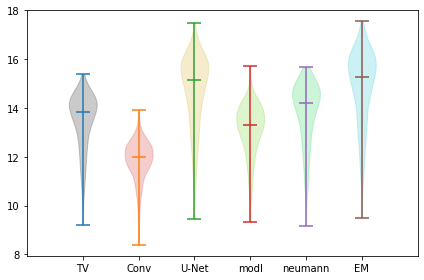

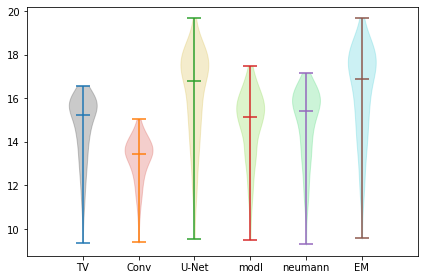

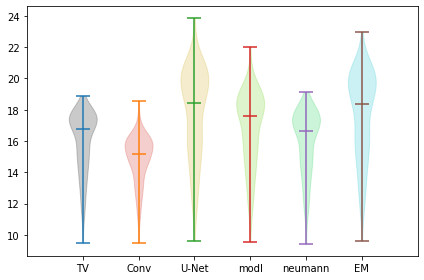

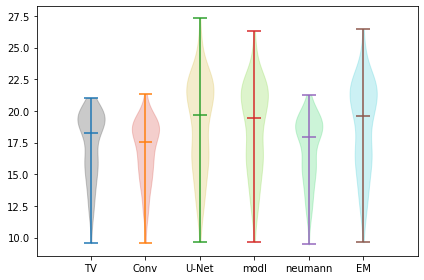

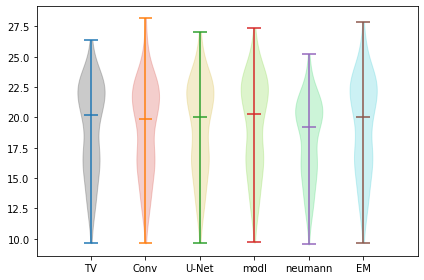

In [20]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


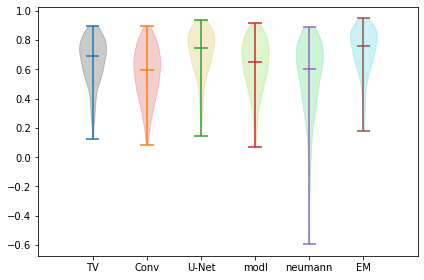

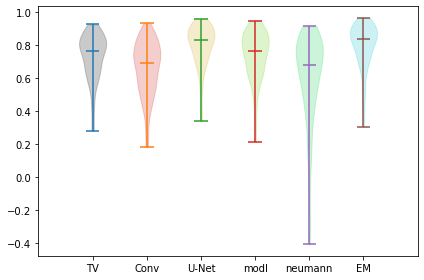

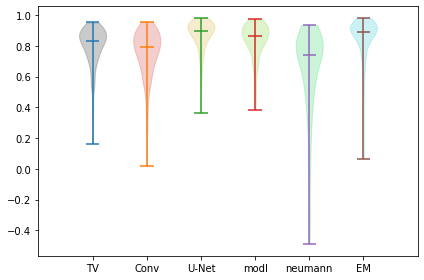

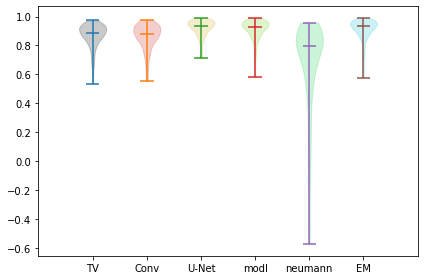

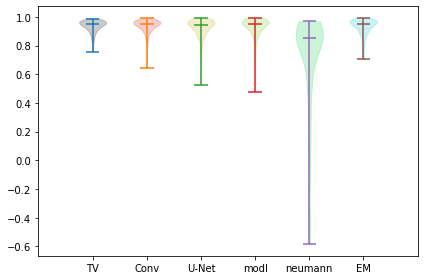

In [21]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)

## Simulated Data (CR = 3/4) 
### Parameters

In [22]:
CR = 1024;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Network

In [23]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNo

In [24]:
net_arch = 2
model_root = '../../models/TCI/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_30_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_30_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [25]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False;
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride

In [26]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [27]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_5 = DConvNet();
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5),

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [28]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "TV" , "Conv", "U-Net", "modl", "neumann", "EM"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_1.N0 = N_0;
    model_2.N0 = N_0;
    model_3.N0 = N_0;
    model_4.N0 = N_0;
    model_5.N0 = N_0;

    n_methods = 6;
#     out_pmdr = "data/pmdr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_psnr = "data/psnr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_ssim = "data/ssim_{}_{}_stl_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "rb")
#         Dico_pmdr = pickle.load(a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
#         pmdr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
#         Dico_pmdr = {};
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
        #     print("Batch :{}/{}".format(batch+1, len(testloader)));
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_1.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

        #             print("TV")
                    outputs = batch_TV(m, batch_size, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.0005, 0.0005]); #too long
                    psnr_list[0]+= batch_psnr(inputs, outputs );
#                     pmdr_list[0]+= batch_pmdr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_5.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs ); 

        #             print("Unet")
                    outputs = model_1.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[2]+= batch_psnr(inputs, outputs );
#                     pmdr_list[1]+= batch_pmdr(inputs, outputs );
                    ssim_list[2]+= batch_ssim(inputs, outputs );

        #             print("Modl")
                    outputs = model_2.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[3]+= batch_psnr(inputs, outputs );
#                     pmdr_list[2]+= batch_pmdr(inputs, outputs );
                    ssim_list[3]+= batch_ssim(inputs, outputs );

        #             print("Neumann")
                    outputs = model_3.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[4]+= batch_psnr(inputs, outputs );
#                     pmdr_list[3]+= batch_pmdr(inputs, outputs );
                    ssim_list[4]+= batch_ssim(inputs, outputs );

        #             print("EM")
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[5]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[5]+= batch_ssim(inputs, outputs );


        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
#         pmdr_list = [np.array(pmdr_list[i]) for i in range(len(pmdr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        
        Dico_psnr["TV"] = psnr_list[0];
        Dico_psnr["Conv"] = psnr_list[1];
        Dico_psnr["U-Net"] = psnr_list[2];
        Dico_psnr["modl"] = psnr_list[3];
        Dico_psnr["neumann"] = psnr_list[4];
        Dico_psnr["EM"] = psnr_list[5];
        
#         Dico_pmdr["TV"] = pmdr_list[0];
#         Dico_pmdr["U-Net"] = pmdr_list[1];
#         Dico_pmdr["modl"] = pmdr_list[2];
#         Dico_pmdr["neumann"] = pmdr_list[3];
#         Dico_pmdr["EM"] = pmdr_list[4];
        
        
        Dico_ssim["TV"] = ssim_list[0];
        Dico_ssim["Conv"] = ssim_list[1];
        Dico_ssim["U-Net"] = ssim_list[2];
        Dico_ssim["modl"] = ssim_list[3];
        Dico_ssim["neumann"] = ssim_list[4];
        Dico_ssim["EM"] = ssim_list[5];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "wb")
#         pickle.dump(Dico_pmdr, a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
#     Dico[N_0] = [Dico_psnr, Dico_pmdr, Dico_ssim];
    Dico[N_0] = [Dico_psnr, Dico_ssim];

        
    




N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


In [29]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_mean = np.round([np.mean(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_std = np.round([np.std(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])
#     Table.append(["{}".format(N_0), "PMDR"] + [r"${:g} \pm {:g}$".format(pmdr_mean[i], pmdr_std[i]) for i in range(len(pmdr_mean))])

In [30]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,TV,Conv,U-Net,modl,neumann,EM
2,PSNR,$11.38 \pm 0.72$,$8.4 \pm 0.85$,$12.81 \pm 0.9$,$10.84 \pm 0.63$,$14.49 \pm 1.71$,$14.2 \pm 1.23$
2,SSIM,$0.54 \pm 0.17$,$0.35 \pm 0.17$,$0.61 \pm 0.18$,$0.5 \pm 0.17$,$0.36 \pm 0.4$,$0.69 \pm 0.17$
3,PSNR,$12.78 \pm 0.93$,$9.67 \pm 0.82$,$14.76 \pm 1.43$,$12.08 \pm 0.78$,$15.27 \pm 2.1$,$15.79 \pm 1.79$
3,SSIM,$0.63 \pm 0.17$,$0.43 \pm 0.19$,$0.72 \pm 0.16$,$0.58 \pm 0.18$,$0.39 \pm 0.43$,$0.78 \pm 0.16$
5,PSNR,$14.41 \pm 1.36$,$11.46 \pm 0.85$,$17.26 \pm 2.52$,$13.95 \pm 1.2$,$16.04 \pm 2.54$,$17.6 \pm 2.67$
5,SSIM,$0.72 \pm 0.15$,$0.55 \pm 0.2$,$0.84 \pm 0.13$,$0.69 \pm 0.17$,$0.43 \pm 0.45$,$0.86 \pm 0.12$
10,PSNR,$16.31 \pm 2.05$,$13.85 \pm 1.19$,$19.27 \pm 3.71$,$16.66 \pm 2.17$,$16.68 \pm 2.97$,$19.07 \pm 3.57$
10,SSIM,$0.83 \pm 0.11$,$0.71 \pm 0.16$,$0.93 \pm 0.07$,$0.84 \pm 0.12$,$0.46 \pm 0.46$,$0.92 \pm 0.07$
50,PSNR,$19.36 \pm 3.7$,$18.35 \pm 3.23$,$19.46 \pm 3.83$,$20.02 \pm 4.19$,$17.07 \pm 3.21$,$19.81 \pm 4.09$
50,SSIM,$0.94 \pm 0.04$,$0.92 \pm 0.05$,$0.93 \pm 0.07$,$0.95 \pm 0.05$,$0.48 \pm 0.47$,$0.95 \pm 0.05$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


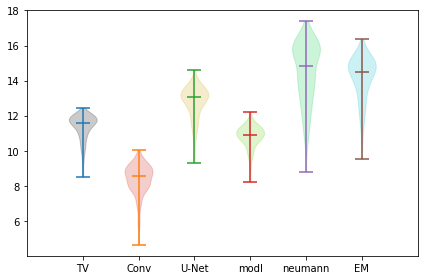

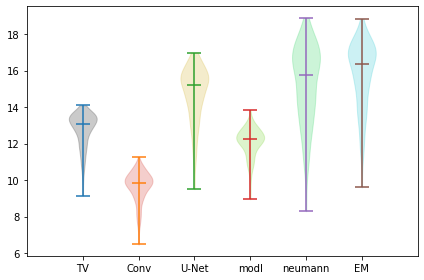

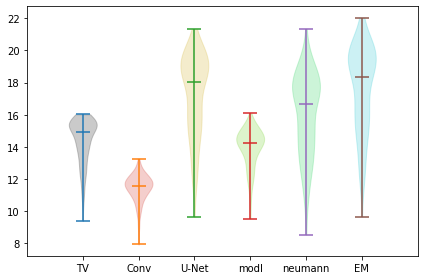

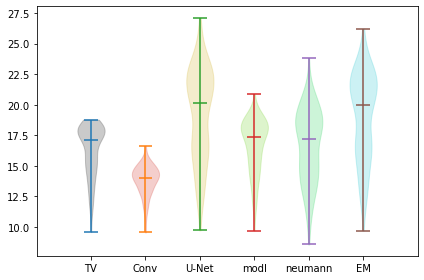

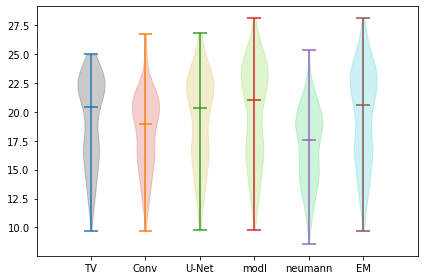

In [31]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


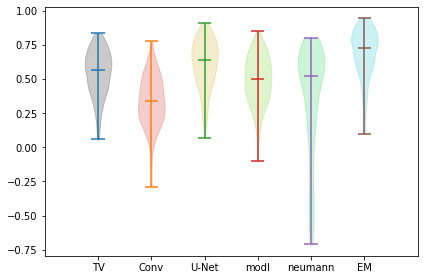

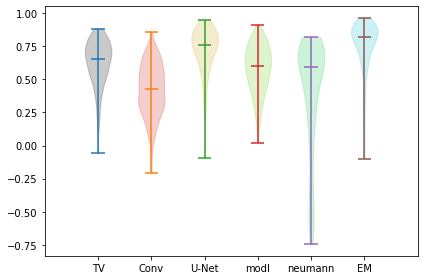

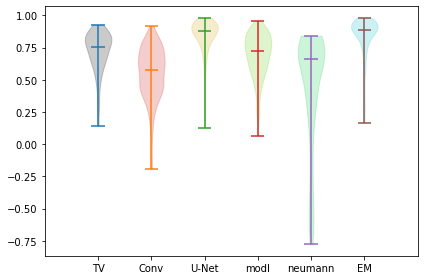

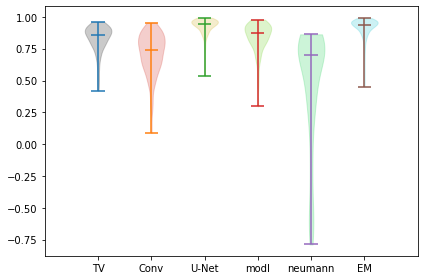

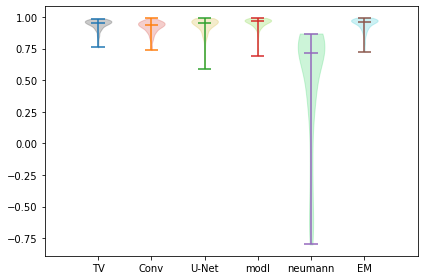

In [32]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)

## Imagenet

In [33]:
from spyrit.learning.imagenet_dataset import NetImage

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])



trainset = \
      NetImage(root=data_root, train = True, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)
testset = \
        NetImage(root=data_root, train = False, transform=transform)
testloader = \
     torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}
num_img = {'train' : len(trainset), 'val' : len(testset)}

## Simulated Data (CR = 7/8) 
### Parameters

In [35]:
CR = 512;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Network

In [36]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/U_net_pinv_N0_10_sig_0_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d

In [37]:
net_arch = 2
model_root = '../../models/TCI_imagenet/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [38]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI_imagenet/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_20_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False; #was done during training script.
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_20_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, 

In [39]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_4 = model_root+"DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_16_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_16_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [40]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5), str

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [41]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "TV" , "Conv", "U-Net", "modl", "neumann", "EM"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_1.N0 = N_0;
    model_2.N0 = N_0;
    model_3.N0 = N_0;
    model_4.N0 = N_0;
    model_5.N0 = N_0;

    n_methods = 6;
#     out_pmdr = "data/pmdr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_psnr = "data/psnr_{}_{}_imagenet_global.pkl".format(N_0, CR);
    out_ssim = "data/ssim_{}_{}_imagenet_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "rb")
#         Dico_pmdr = pickle.load(a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
#         pmdr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
#         Dico_pmdr = {};
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
        #     print("Batch :{}/{}".format(batch+1, len(testloader)));
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_1.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

        #             print("TV")
                    outputs = batch_TV(m, batch_size, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.0005, 0.0005]); #too long
                    psnr_list[0]+= batch_psnr(inputs, outputs );
#                     pmdr_list[0]+= batch_pmdr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_5.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs ); 

        #             print("Unet")
                    outputs = model_1.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[2]+= batch_psnr(inputs, outputs );
#                     pmdr_list[1]+= batch_pmdr(inputs, outputs );
                    ssim_list[2]+= batch_ssim(inputs, outputs );

        #             print("Modl")
                    outputs = model_2.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[3]+= batch_psnr(inputs, outputs );
#                     pmdr_list[2]+= batch_pmdr(inputs, outputs );
                    ssim_list[3]+= batch_ssim(inputs, outputs );

        #             print("Neumann")
                    outputs = model_3.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[4]+= batch_psnr(inputs, outputs );
#                     pmdr_list[3]+= batch_pmdr(inputs, outputs );
                    ssim_list[4]+= batch_ssim(inputs, outputs );

        #             print("EM")
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[5]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[5]+= batch_ssim(inputs, outputs );


        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
#         pmdr_list = [np.array(pmdr_list[i]) for i in range(len(pmdr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        
        Dico_psnr["TV"] = psnr_list[0];
        Dico_psnr["Conv"] = psnr_list[1];
        Dico_psnr["U-Net"] = psnr_list[2];
        Dico_psnr["modl"] = psnr_list[3];
        Dico_psnr["neumann"] = psnr_list[4];
        Dico_psnr["EM"] = psnr_list[5];
        
#         Dico_pmdr["TV"] = pmdr_list[0];
#         Dico_pmdr["U-Net"] = pmdr_list[1];
#         Dico_pmdr["modl"] = pmdr_list[2];
#         Dico_pmdr["neumann"] = pmdr_list[3];
#         Dico_pmdr["EM"] = pmdr_list[4];
        
        
        Dico_ssim["TV"] = ssim_list[0];
        Dico_ssim["Conv"] = ssim_list[1];
        Dico_ssim["U-Net"] = ssim_list[2];
        Dico_ssim["modl"] = ssim_list[3];
        Dico_ssim["neumann"] = ssim_list[4];
        Dico_ssim["EM"] = ssim_list[5];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "wb")
#         pickle.dump(Dico_pmdr, a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
#     Dico[N_0] = [Dico_psnr, Dico_pmdr, Dico_ssim];
    Dico[N_0] = [Dico_psnr, Dico_ssim];

N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


In [42]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_mean = np.round([np.mean(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_std = np.round([np.std(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])
#     Table.append(["{}".format(N_0), "PMDR"] + [r"${:g} \pm {:g}$".format(pmdr_mean[i], pmdr_std[i]) for i in range(len(pmdr_mean))])

In [43]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,TV,Conv,U-Net,modl,neumann,EM
2,PSNR,$13.03 \pm 1.49$,$11.84 \pm 1.06$,$13.92 \pm 1.78$,$12.52 \pm 1.31$,$14.21 \pm 2.06$,$14.35 \pm 1.92$
2,SSIM,$0.64 \pm 0.16$,$0.57 \pm 0.18$,$0.69 \pm 0.16$,$0.62 \pm 0.17$,$0.48 \pm 0.33$,$0.72 \pm 0.16$
3,PSNR,$14.07 \pm 1.83$,$12.94 \pm 1.35$,$15.27 \pm 2.35$,$14.03 \pm 1.83$,$14.82 \pm 2.35$,$15.52 \pm 2.46$
3,SSIM,$0.71 \pm 0.14$,$0.65 \pm 0.17$,$0.77 \pm 0.14$,$0.7 \pm 0.17$,$0.51 \pm 0.35$,$0.79 \pm 0.14$
5,PSNR,$15.22 \pm 2.35$,$14.35 \pm 1.92$,$16.74 \pm 3.23$,$15.74 \pm 2.63$,$15.37 \pm 2.67$,$16.71 \pm 3.2$
5,SSIM,$0.79 \pm 0.12$,$0.75 \pm 0.14$,$0.85 \pm 0.1$,$0.81 \pm 0.12$,$0.54 \pm 0.34$,$0.86 \pm 0.1$
10,PSNR,$16.39 \pm 2.96$,$16.03 \pm 2.77$,$17.74 \pm 3.96$,$17.37 \pm 3.66$,$15.82 \pm 2.94$,$17.6 \pm 3.85$
10,SSIM,$0.85 \pm 0.09$,$0.85 \pm 0.09$,$0.9 \pm 0.07$,$0.89 \pm 0.08$,$0.56 \pm 0.36$,$0.9 \pm 0.07$
50,PSNR,$17.89 \pm 4.01$,$17.89 \pm 4.12$,$17.97 \pm 4.09$,$18.22 \pm 4.28$,$16.2 \pm 3.18$,$18.08 \pm 4.21$
50,SSIM,$0.92 \pm 0.06$,$0.92 \pm 0.06$,$0.91 \pm 0.08$,$0.91 \pm 0.08$,$0.6 \pm 0.34$,$0.91 \pm 0.08$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


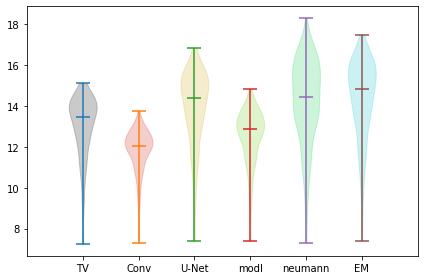

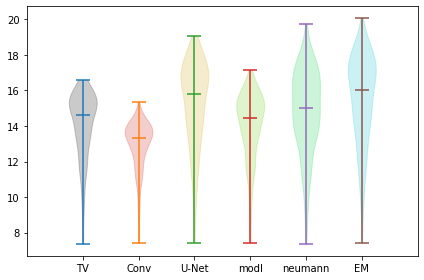

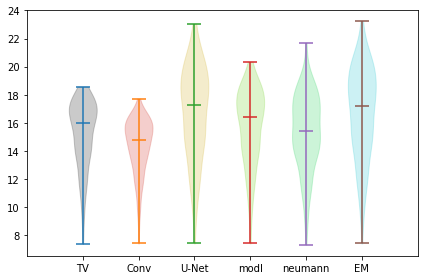

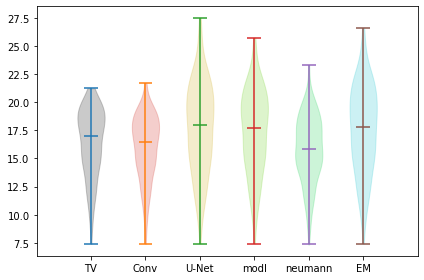

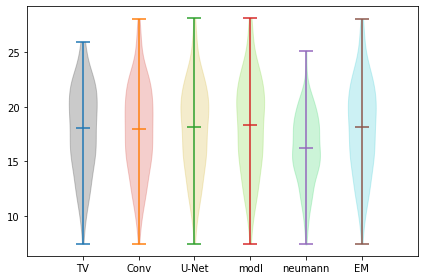

In [44]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


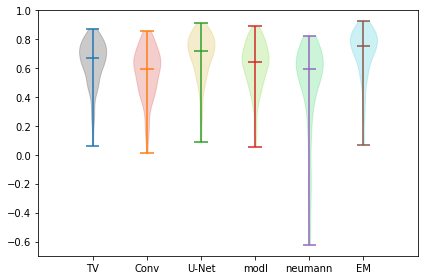

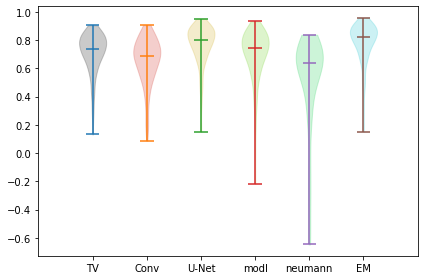

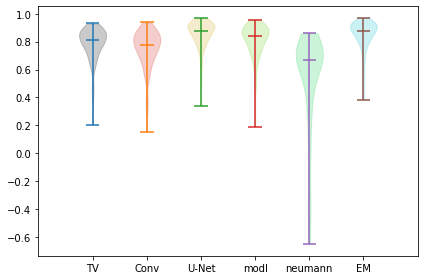

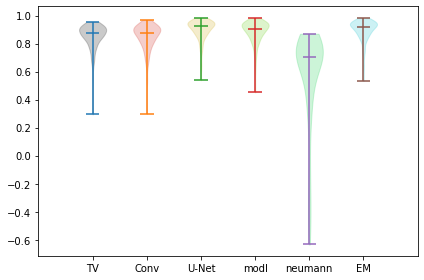

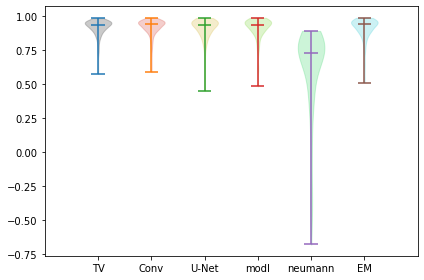

In [45]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)

## Simulated Data (CR = 3/4) 
### Parameters

In [46]:
CR = 1024;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Network

In [47]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNo

In [48]:
net_arch = 2
model_root = '../../models/TCI_imagenet/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_10_lr_0.001_sss_3_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_10_lr_0.001_sss_3_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [49]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI_imagenet/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False; #was done during training script.
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride

In [50]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_4 = model_root+"DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [51]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5),

### Compute Metrics Over the Test-set $N_0 = [2,5,10,50]$

In [52]:
# N0_list = [5, 10, 50, 2500];
N0_list = [2, 3, 5, 10, 50];
# N0_list = [2500];
title_list = ["GT", "TV" , "Conv", "U-Net", "modl", "neumann", "EM"]
torch.manual_seed(1)
Dico = {}

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    model_1.N0 = N_0;
    model_2.N0 = N_0;
    model_3.N0 = N_0;
    model_4.N0 = N_0;
    model_5.N0 = N_0;

    n_methods = 6;
#     out_pmdr = "data/pmdr_{}_{}_stl_global.pkl".format(N_0, CR);
    out_psnr = "data/psnr_{}_{}_imagenet_global.pkl".format(N_0, CR);
    out_ssim = "data/ssim_{}_{}_imagenet_global.pkl".format(N_0, CR);
    if os.path.isfile(out_psnr) and os.path.isfile(out_ssim):
        a_file = open(out_psnr, "rb")
        Dico_psnr = pickle.load(a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "rb")
#         Dico_pmdr = pickle.load(a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "rb")
        Dico_ssim = pickle.load(a_file)
        a_file.close()
        
    else :
        psnr_list = [[] for i in range(n_methods)];
#         pmdr_list = [[] for i in range(n_methods)];
        ssim_list = [[] for i in range(n_methods)];
#         Dico_pmdr = {};
        Dico_psnr = {};
        Dico_ssim = {};
        for batch, (inputs, labels) in enumerate(testloader):
            [batch_size, c, h, w] = inputs.shape;
        #     print("Batch :{}/{}".format(batch+1, len(testloader)));
            inputs = inputs.to(device);
            if batch*batch_size < 200:
                print("No = {}, batch = {} /{} ".format(N_0, batch, len(testloader)))
                with torch.no_grad():
                    m = model_1.forward_acquire(inputs ,batch_size, 1, img_size, img_size);

        #             print("TV")
                    outputs = batch_TV(m, batch_size, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.0005, 0.0005]); #too long
                    psnr_list[0]+= batch_psnr(inputs, outputs );
#                     pmdr_list[0]+= batch_pmdr(inputs, outputs );
                    ssim_list[0]+= batch_ssim(inputs, outputs );
    
                    outputs = model_5.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[1]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[1]+= batch_ssim(inputs, outputs ); 

        #             print("Unet")
                    outputs = model_1.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[2]+= batch_psnr(inputs, outputs );
#                     pmdr_list[1]+= batch_pmdr(inputs, outputs );
                    ssim_list[2]+= batch_ssim(inputs, outputs );

        #             print("Modl")
                    outputs = model_2.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[3]+= batch_psnr(inputs, outputs );
#                     pmdr_list[2]+= batch_pmdr(inputs, outputs );
                    ssim_list[3]+= batch_ssim(inputs, outputs );

        #             print("Neumann")
                    outputs = model_3.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[4]+= batch_psnr(inputs, outputs );
#                     pmdr_list[3]+= batch_pmdr(inputs, outputs );
                    ssim_list[4]+= batch_ssim(inputs, outputs );

        #             print("EM")
                    outputs = model_4.forward_reconstruct(m, batch_size, 1, img_size, img_size);
                    psnr_list[5]+= batch_psnr(inputs, outputs );
#                     pmdr_list[4]+= batch_pmdr(inputs, outputs );
                    ssim_list[5]+= batch_ssim(inputs, outputs );


        psnr_list = [np.array(psnr_list[i]) for i in range(len(psnr_list))];
#         pmdr_list = [np.array(pmdr_list[i]) for i in range(len(pmdr_list))];
        ssim_list = [np.array(ssim_list[i]) for i in range(len(ssim_list))];
        
        Dico_psnr["TV"] = psnr_list[0];
        Dico_psnr["Conv"] = psnr_list[1];
        Dico_psnr["U-Net"] = psnr_list[2];
        Dico_psnr["modl"] = psnr_list[3];
        Dico_psnr["neumann"] = psnr_list[4];
        Dico_psnr["EM"] = psnr_list[5];
        
#         Dico_pmdr["TV"] = pmdr_list[0];
#         Dico_pmdr["U-Net"] = pmdr_list[1];
#         Dico_pmdr["modl"] = pmdr_list[2];
#         Dico_pmdr["neumann"] = pmdr_list[3];
#         Dico_pmdr["EM"] = pmdr_list[4];
        
        
        Dico_ssim["TV"] = ssim_list[0];
        Dico_ssim["Conv"] = ssim_list[1];
        Dico_ssim["U-Net"] = ssim_list[2];
        Dico_ssim["modl"] = ssim_list[3];
        Dico_ssim["neumann"] = ssim_list[4];
        Dico_ssim["EM"] = ssim_list[5];
        
        
        a_file = open(out_psnr, "wb")
        pickle.dump(Dico_psnr, a_file)
        a_file.close()
        
#         a_file = open(out_pmdr, "wb")
#         pickle.dump(Dico_pmdr, a_file)
#         a_file.close()
        
        a_file = open(out_ssim, "wb")
        pickle.dump(Dico_ssim, a_file)
        a_file.close()
        
#     Dico[N_0] = [Dico_psnr, Dico_pmdr, Dico_ssim];
    Dico[N_0] = [Dico_psnr, Dico_ssim];

N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


In [53]:
Table = [[r"$\alpha$", " "]+title_list[1:]];
for N_0 in N0_list :
    
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    
    psnr_mean = np.round([np.mean(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_mean = np.round([np.mean(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_mean = np.round([np.mean(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    psnr_std = np.round([np.std(psnr_list[i]) for i in range(len(psnr_list))],2);
#     pmdr_std = np.round([np.std(pmdr_list[i]) for i in range(len(pmdr_list))],2);
    ssim_std = np.round([np.std(ssim_list[i]) for i in range(len(ssim_list))],2);
    
    Table.append(["{}".format(N_0), "PSNR"] + [r"${} \pm {}$".format(psnr_mean[i], psnr_std[i]) for i in range(len(psnr_mean))])
    Table.append(["{}".format(N_0), "SSIM"] + [r"${} \pm {}$".format(ssim_mean[i], ssim_std[i]) for i in range(len(ssim_mean))])
#     Table.append(["{}".format(N_0), "PMDR"] + [r"${:g} \pm {:g}$".format(pmdr_mean[i], pmdr_std[i]) for i in range(len(pmdr_mean))])

In [54]:
display(HTML(data="""
<style>
    div#notebook-container    {width: 100%;}
    div#menubar-container     {width: 100%;}
    div#maintoolbar-container {width: 100%;}
</style>
"""))
display(HTML(tabulate.tabulate(Table, tablefmt='html')))


$\alpha$,,TV,Conv,U-Net,modl,neumann,EM
2,PSNR,$11.13 \pm 1.02$,$9.56 \pm 0.7$,$12.42 \pm 1.19$,$9.77 \pm 0.63$,$13.22 \pm 1.58$,$13.83 \pm 1.65$
2,SSIM,$0.53 \pm 0.16$,$0.41 \pm 0.18$,$0.6 \pm 0.17$,$0.41 \pm 0.17$,$0.53 \pm 0.26$,$0.69 \pm 0.17$
3,PSNR,$12.42 \pm 1.29$,$10.49 \pm 0.82$,$14.16 \pm 1.79$,$10.88 \pm 0.82$,$14.34 \pm 2.01$,$15.17 \pm 2.23$
3,SSIM,$0.62 \pm 0.15$,$0.49 \pm 0.17$,$0.71 \pm 0.15$,$0.51 \pm 0.17$,$0.6 \pm 0.26$,$0.77 \pm 0.15$
5,PSNR,$13.9 \pm 1.76$,$11.75 \pm 1.04$,$16.32 \pm 2.88$,$12.6 \pm 1.25$,$15.49 \pm 2.56$,$16.65 \pm 3.08$
5,SSIM,$0.72 \pm 0.13$,$0.59 \pm 0.17$,$0.84 \pm 0.11$,$0.64 \pm 0.16$,$0.66 \pm 0.27$,$0.85 \pm 0.11$
10,PSNR,$15.58 \pm 2.47$,$13.62 \pm 1.58$,$18.05 \pm 4.11$,$15.08 \pm 2.17$,$16.53 \pm 3.16$,$17.84 \pm 3.94$
10,SSIM,$0.82 \pm 0.1$,$0.73 \pm 0.14$,$0.91 \pm 0.07$,$0.8 \pm 0.12$,$0.7 \pm 0.28$,$0.91 \pm 0.07$
50,PSNR,$18.11 \pm 4.02$,$17.3 \pm 3.66$,$18.2 \pm 4.21$,$18.65 \pm 4.53$,$17.42 \pm 3.79$,$18.41 \pm 4.4$
50,SSIM,$0.93 \pm 0.05$,$0.91 \pm 0.06$,$0.91 \pm 0.08$,$0.94 \pm 0.06$,$0.72 \pm 0.32$,$0.92 \pm 0.07$


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


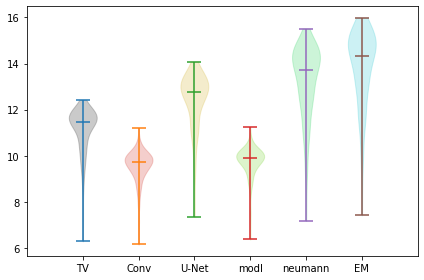

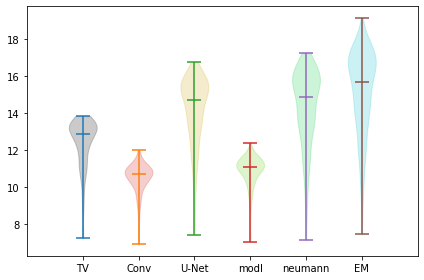

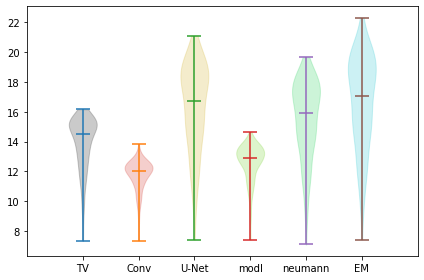

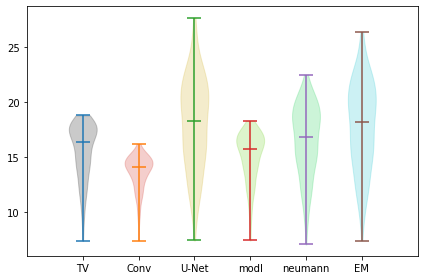

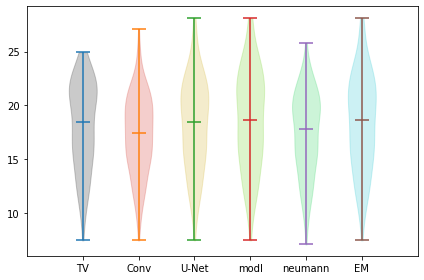

In [55]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = psnr_list[j];
    dico2violinplot(Dico_1, color)


N0 = 2
N0 = 3
N0 = 5
N0 = 10
N0 = 50


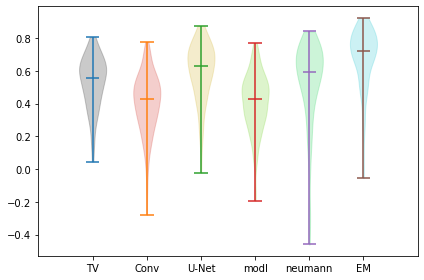

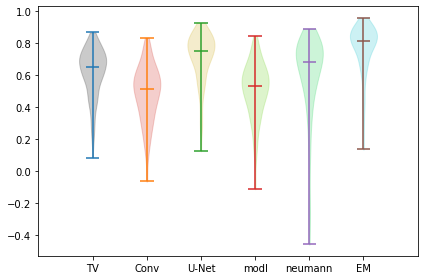

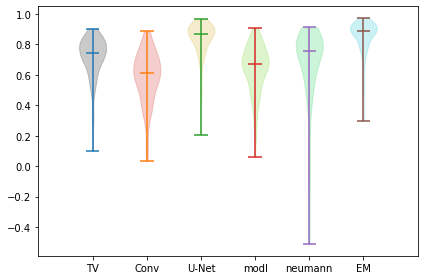

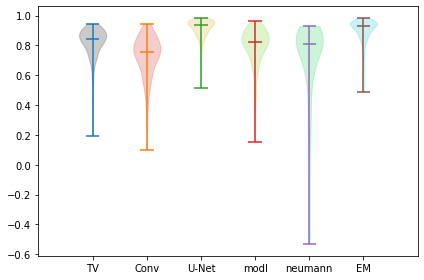

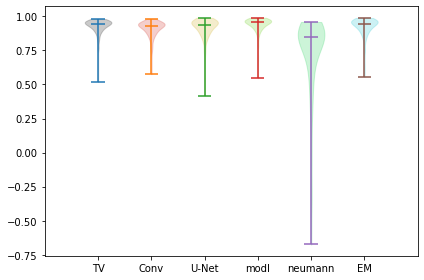

In [56]:
%matplotlib inline
pal = sns.color_palette("hls", 8)
color = ['#525252']+pal.as_hex()

for N_0 in N0_list :
    print("N0 = {}".format(N_0))
    psnr_list = [Dico[N_0][0][title_list[i]] for i in range(1,len(title_list))]
    ssim_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
#     pmdr_list = [Dico[N_0][1][title_list[i]] for i in range(1,len(title_list))]
    Dico_1 = {}

    for j in range(n_methods):
        Dico_1[title_list[j+1]] = ssim_list[j];
    dico2violinplot(Dico_1, color)